# Singel-label classification

> <i>This tutorial highlights how to quickly build a Learner and train a model on a binary classification task.</i>

## Beginner

The following line imports all of the functions and classes from the fastMONAI library: 

In [1]:
from fastMONAI.vision_all import *

### Download external data
For this task, we will download the T1-weighted brain images of healthy subjects (n=556) from the IXI dataset (https://brain-development.org/ixi-dataset/) with the corresponding metadata. We will download the data with the following line of code. Note that the data set is ~ 4.5G, and the download may take some time.

In [2]:
path = Path('../data')

In [3]:
STUDY_DIR = download_ixi_data(path=path)

2022-08-31 13:23:49,356 - INFO - Expected md5 is None, skip md5 check for file ../data/IXI/IXI-T1.tar.
2022-08-31 13:23:49,358 - INFO - File exists: ../data/IXI/IXI-T1.tar, skipped downloading.
2022-08-31 13:23:49,359 - INFO - Writing into directory: ../data/IXI/T1_images.
2022-08-31 13:23:52,026 - INFO - Expected md5 is None, skip md5 check for file ../data/IXI/IXI.xls.
2022-08-31 13:23:52,027 - INFO - File exists: ../data/IXI/IXI.xls, skipped downloading.
Preprocessing ../data/IXI/IXI.xls


### Looking at data

Let's look at how the processed DataFrame is formatted: 

In [4]:
df = pd.read_csv(STUDY_DIR/'dataset.csv')

In [5]:
df.head()

,t1_path,subject_id,gender,age_at_scan
0,../data/IXI/T1_images/IXI002-Guys-0828-T1.nii.gz,IXI002,F,35.80
1,../data/IXI/T1_images/IXI012-HH-1211-T1.nii.gz,IXI012,M,38.78
2,../data/IXI/T1_images/IXI013-HH-1212-T1.nii.gz,IXI013,M,46.71
3,../data/IXI/T1_images/IXI014-HH-1236-T1.nii.gz,IXI014,F,34.24
4,../data/IXI/T1_images/IXI015-HH-1258-T1.nii.gz,IXI015,M,24.28


efore feeding the data into a model, we must create a `DataLoaders` object for our dataset. There are several ways to get the data in `DataLoaders`. 
In the following line, we call the ` ImageDataLoaders.from_df` factory method, which is the most basic way of building a `DataLoaders`. 

Here, we pass the processed DataFrame, define the columns for the images `fn_col` and the labels `label_col`, voxel spacing `resample`, some transforms `item_tfms`, and the batch size `bs`. 

In [6]:
dls = MedImageDataLoaders.from_df(df, fn_col='t1_path', label_col='gender', resample=1, item_tfms=[ZNormalization(), PadOrCrop(size=256)], bs=4)

We can now take a look at a batch of images in the training set using `show_batch`:

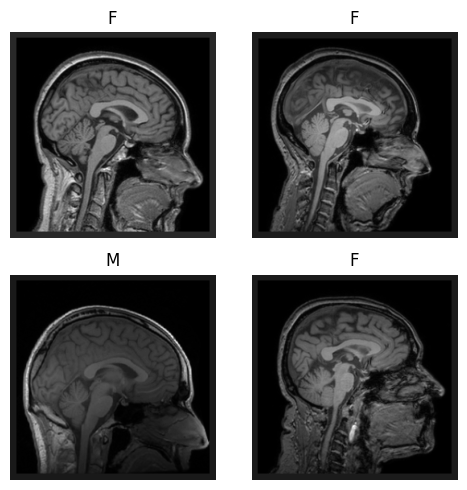

In [7]:
dls.show_batch(figsize=(5,5),anatomical_plane=2)

### Create and train a 3D model 

Next, we import a classification network from MONAI, and define the input image size, number of classes to predict, channels, etc.  

In [8]:
from monai.networks.nets import Classifier

model = Classifier(in_shape=[1, 256, 256, 256], classes=2, channels=(8, 16, 32, 64, 128),strides=(2, 2, 2, 2))

Then we can create a `Learner`, which is a fastai object that combines the data and our defined model for training:

In [9]:
learn = Learner(dls, model, metrics=accuracy)

In [11]:
%%time
learn.fit_one_cycle(2)

epoch,train_loss,valid_loss,accuracy,time
0,17.494049,23.210430,0.750000,01:51
1,7.900735,7.798369,0.875000,01:51


CPU times: user 1min 13s, sys: 23.2 s, total: 1min 36s
Wall time: 3min 43s


With the model trained, let's look at some predictions on the validation data.

> **Note:** Small random variations are involved in training CNN models. Hence, when running the notebook, you will probably not see exactly the same results shown here.

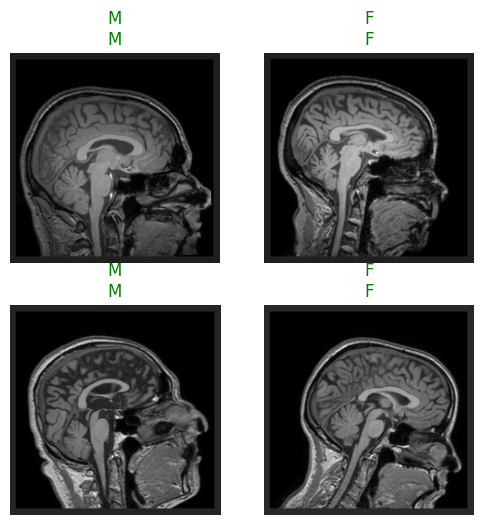

In [12]:
learn.show_results(anatomical_plane=2)

Showing samples with target value their corresponding predictions (target|predicition). todo

In [13]:
learn.save('model-1')

Path('models/model-1.pth')

### Inference

We can have a look at where our trained model becomes confused while making predictions on the validation data:

In [14]:
learn.load('model-1');

In [15]:
interp = ClassificationInterpretation.from_learner(learn)

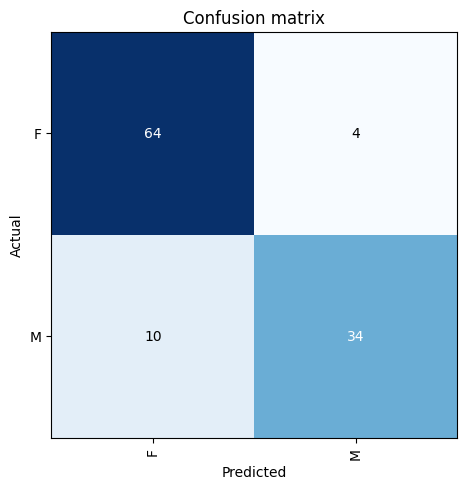

In [16]:
interp.plot_confusion_matrix()

In [17]:
interp.print_classification_report()

              precision    recall  f1-score   support

           F       0.86      0.94      0.90        68
           M       0.89      0.77      0.83        44

    accuracy                           0.88       112
   macro avg       0.88      0.86      0.87       112
weighted avg       0.88      0.88      0.87       112



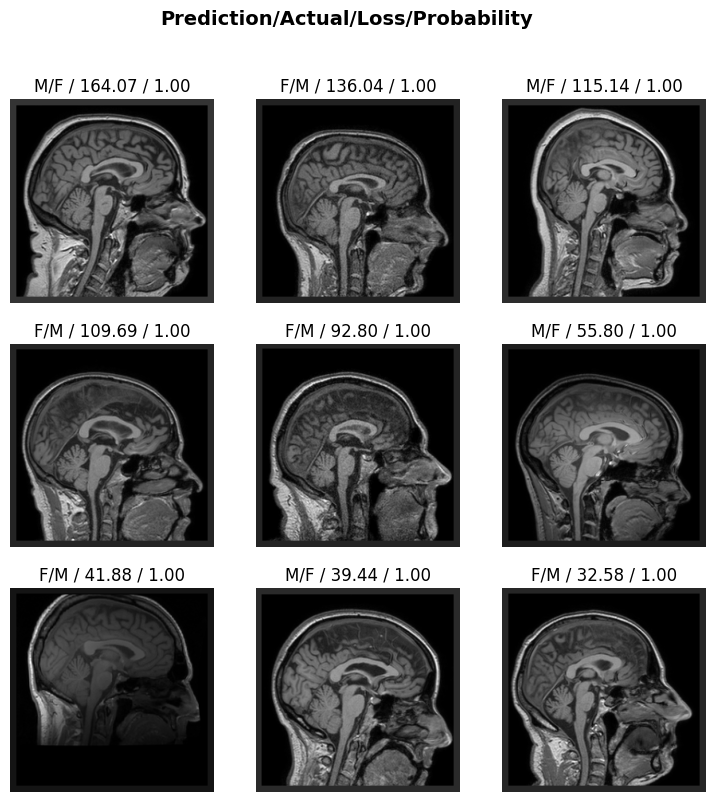

In [18]:
interp.plot_top_losses(k=9, anatomical_plane=2) 

## Advanced

`fastMONAI.vision_all import *` imports the following: 

In [19]:
from fastMONAI.vision_core import *
from fastMONAI.vision_data import *
from fastMONAI.vision_augmentation import *
from fastMONAI.vision_loss import *
from fastMONAI.vision_metrics import * 
from fastMONAI.vision_utils import * 
from fastMONAI.external_data import *
from fastMONAI.dataset_info import *

from fastai.vision.all import *

Grab the data (if not already been fetched).

In [20]:
STUDY_DIR = download_ixi_data()
df = pd.read_csv(STUDY_DIR/'dataset.csv')

2022-08-31 13:33:48,753 - INFO - Expected md5 is None, skip md5 check for file ../data/IXI/IXI-T1.tar.
2022-08-31 13:33:48,753 - INFO - File exists: ../data/IXI/IXI-T1.tar, skipped downloading.
2022-08-31 13:33:48,754 - INFO - Writing into directory: ../data/IXI/T1_images.
2022-08-31 13:33:51,517 - INFO - Expected md5 is None, skip md5 check for file ../data/IXI/IXI.xls.
2022-08-31 13:33:51,517 - INFO - File exists: ../data/IXI/IXI.xls, skipped downloading.
Preprocessing ../data/IXI/IXI.xls


### Get information about the dataset

`MedDataset` is a class to extract and present information about your dataset.

In [21]:
med_dataset = MedDataset(path=STUDY_DIR/'T1_images', max_workers=12)

In [22]:
data_info_df = med_dataset.summary()

In [23]:
data_info_df.head()

,dim_0,dim_1,dim_2,voxel_0,voxel_1,voxel_2,orientation,example_path,total
3,256,256,150,0.9375,0.9375,1.2,PSR+,../data/IXI/T1_images/IXI002-Guys-0828-T1.nii.gz,498
2,256,256,146,0.9375,0.9375,1.2,PSR+,../data/IXI/T1_images/IXI035-IOP-0873-T1.nii.gz,74
4,256,256,150,0.9766,0.9766,1.2,PSR+,../data/IXI/T1_images/IXI297-Guys-0886-T1.nii.gz,5
0,256,256,130,0.9375,0.9375,1.2,PSR+,../data/IXI/T1_images/IXI023-Guys-0699-T1.nii.gz,2
1,256,256,140,0.9375,0.9375,1.2,PSR+,../data/IXI/T1_images/IXI020-Guys-0700-T1.nii.gz,2


In [24]:
resample, reorder = med_dataset.suggestion()
resample, reorder

([0.9375, 0.9375, 1.2], False)

In [25]:
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[267.0, 267.0, 150.0]

In [26]:
bs=4
in_shape = [1, 256, 256, 160]

In [27]:
item_tfms = [ZNormalization(), PadOrCrop(in_shape[1:]), RandomAffine(scales=0, degrees=5, isotropic=True)] 

As we mentioned earlier, there are several ways to get the data in `DataLoaders`. In this section, let's rebuild using `DataBlock`. 
Here we need to define what our input and target should be (`MedImage` and `CategoryBlock` for classification), how to get the images and the labels, how to split the data, item transforms that should be applied during training, reorder voxel orientations, and voxel spacing. Take a look at fastai's documentation for DataBlock for further information: https://docs.fast.ai/data.block.html#DataBlock. 

In [28]:
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), CategoryBlock), 
                      splitter=RandomSplitter(seed=42),
                      get_x=ColReader('t1_path'),
                      get_y=ColReader('gender'),
                      item_tfms=item_tfms, 
                      reorder=reorder,
                      resample=resample)

Now we pass our processed DataFrame and the bath size to create a `DataLoaders` object. 

In [29]:
dls = dblock.dataloaders(df, bs=bs)

In [30]:
len(dls.train_ds.items), len(dls.valid_ds.items)

(449, 112)

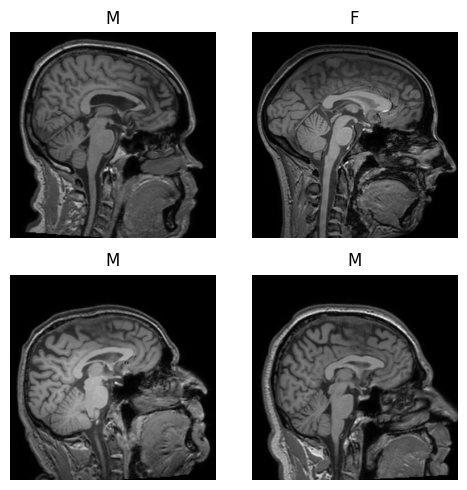

In [31]:
dls.show_batch(max_n=6, figsize=(5, 5), anatomical_plane=2)

In [32]:
from monai.networks.nets import Classifier

model = Classifier(in_shape=[1, 256, 256, 160], classes=2, channels=(8, 16, 32, 64, 128),
                   strides=(2, 2, 2, 2), kernel_size=3, num_res_units=2)

In [34]:
learn = Learner(dls, model, metrics=[accuracy])

CPU times: user 667 µs, sys: 235 µs, total: 902 µs
Wall time: 911 µs


In [35]:
learn.summary()

Classifier (Input shape: 4 x 1 x 256 x 256 x 160)
Layer (type)         Output Shape         Param #    Trainable 
                     4 x 8 x 128 x 128 x 
Conv3d                                    224        True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    1736       True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    224        True      
____________________________________________________________________________
                     4 x 16 x 64 x 64 x  
Conv3d                                    3472       True      
InstanceNorm3d                            0          False     
PReLU                                     1          True      
Conv3d                                    6928       True      
InstanceNorm3d       

We used the default learning rate before, but we might want to find an optimal value. For this, we can use the learning rate finder. 
Rule of thumb to pick a learning rate: 
- Minimum/10 
- The steepest point(where the loss is clearly decreasing)

CPU times: user 11.7 s, sys: 3.35 s, total: 15.1 s
Wall time: 32.5 s


SuggestedLRs(valley=2.75422871709452e-06)

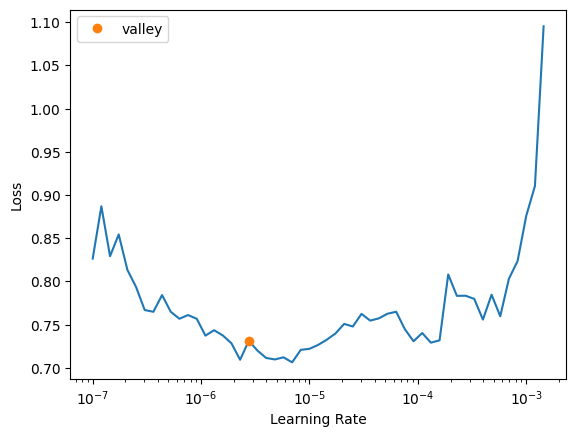

In [36]:
%%time
learn.lr_find()

In [37]:
lr = 5e-4

In [38]:
%%time
learn.fit_one_cycle(4, lr)

epoch,train_loss,valid_loss,accuracy,time
0,1.039559,7.525472,0.607143,00:59
1,4.023092,1.219575,0.866071,00:57
2,0.936260,0.375488,0.937500,00:57
3,0.294504,0.198751,0.973214,00:56


CPU times: user 1min 37s, sys: 29.3 s, total: 2min 6s
Wall time: 3min 51s


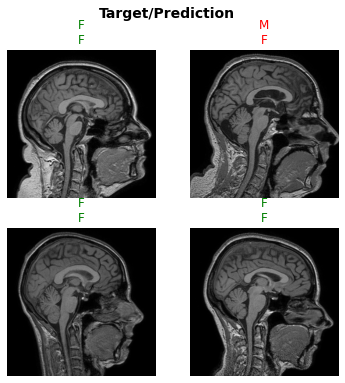

In [ ]:
learn.show_results(anatomical_plane=2)

In [39]:
learn.save('model-2')

Path('models/model-2.pth')

## Test-time augmentation

Test-time augmentation (TTA) is a technique where you apply transforms used during traing when making predictions to produce average output.  

In [41]:
learn.load('model-2');

In [42]:
%%time
preds, targs = learn.tta(); 

CPU times: user 13 s, sys: 7.89 s, total: 20.9 s
Wall time: 59.5 s


In [43]:
accuracy(preds, targs)

TensorBase(0.9643)